In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

In [ ]:
import warnings
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D 
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import tensorflow as tf
import tensorflow.keras
import IPython
%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
from numpy.random import seed

In [ ]:
dataset_finale = pd.read_excel(r'/content/drive/MyDrive/dataset_finale.xlsx')
dataset_finale['Vento'] = dataset_finale['Vento'].map(lambda x: x.rstrip(' km/h')) # elimino il ' km/' 
dataset_finale = dataset_finale.astype({"Vento": int}) # trasformo in int

dataset_finale['Wind_Angle'] = dataset_finale['Wind Direction'].replace('N', 360).replace('NNE', 22.5).replace('NE', 45).replace('ENE', 67.5).replace(
  'E', 90).replace('ESE', 112.5).replace('SE', 135).replace('SSE', 157.5).replace('S', 180).replace('SSW', 202.5).replace('SW', 225).replace(
    'WSW', 247.5).replace('W', 270).replace('WNW', 292.5).replace('NW', 315).replace('NNW', 337.5)

PM10 = dataset_finale['PM10']
df = dataset_finale.drop(columns = ['Wind Direction', 'PM10'])
df = pd.concat((df, PM10), axis = 1)
df = df.rename(columns = {'T Media': 'Temperature', 'H': 'Humidity', 'Vento': 'Wind_Speed', 'Pressione': 'Pressure'})
df.head()

,datetime,Temperature,Humidity,Wind_Speed,Pressure,Wind_Angle,PM10
0,2019-01-01,7,54,17,1023,22.5,27
1,2019-01-02,5,77,12,1014,67.5,34
2,2019-01-03,3,68,22,1019,22.5,5
3,2019-01-04,1,84,15,1025,360.0,9
4,2019-01-05,3,79,8,1022,337.5,59


In [ ]:
df = df.astype({"Wind_Angle": 'category'}) # converto l'angolo in type categorico
df.dtypes

datetime       datetime64[ns]
Temperature             int64
Humidity                int64
Wind_Speed              int64
Pressure                int64
Wind_Angle           category
PM10                    int64
dtype: object

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 7
lag = 1
series = series_to_supervised(df.drop('datetime', axis=1), window=window, lag=lag)
print(series.columns)
series.head()

Index(['Temperature(t-7)', 'Humidity(t-7)', 'Wind_Speed(t-7)', 'Pressure(t-7)',
       'Wind_Angle(t-7)', 'PM10(t-7)', 'Temperature(t-6)', 'Humidity(t-6)',
       'Wind_Speed(t-6)', 'Pressure(t-6)', 'Wind_Angle(t-6)', 'PM10(t-6)',
       'Temperature(t-5)', 'Humidity(t-5)', 'Wind_Speed(t-5)', 'Pressure(t-5)',
       'Wind_Angle(t-5)', 'PM10(t-5)', 'Temperature(t-4)', 'Humidity(t-4)',
       'Wind_Speed(t-4)', 'Pressure(t-4)', 'Wind_Angle(t-4)', 'PM10(t-4)',
       'Temperature(t-3)', 'Humidity(t-3)', 'Wind_Speed(t-3)', 'Pressure(t-3)',
       'Wind_Angle(t-3)', 'PM10(t-3)', 'Temperature(t-2)', 'Humidity(t-2)',
       'Wind_Speed(t-2)', 'Pressure(t-2)', 'Wind_Angle(t-2)', 'PM10(t-2)',
       'Temperature(t-1)', 'Humidity(t-1)', 'Wind_Speed(t-1)', 'Pressure(t-1)',
       'Wind_Angle(t-1)', 'PM10(t-1)', 'Temperature(t)', 'Humidity(t)',
       'Wind_Speed(t)', 'Pressure(t)', 'Wind_Angle(t)', 'PM10(t)'],
      dtype='object')


,Temperature(t-7),Humidity(t-7),Wind_Speed(t-7),Pressure(t-7),Wind_Angle(t-7),PM10(t-7),Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM10(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM10(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM10(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM10(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM10(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM10(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t),PM10(t)
7,7.0,54.0,17.0,1023.0,22.5,27.0,5.0,77.0,12.0,1014.0,67.5,34.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5,80,6,1019,67.5,67
8,5.0,77.0,12.0,1014.0,67.5,34.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7,83,13,1003,45.0,57
9,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6,83,8,1005,22.5,38
10,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6.0,83.0,8.0,1005.0,22.5,38.0,3,81,17,1014,45.0,28
11,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6.0,83.0,8.0,1005.0,22.5,38.0,3.0,81.0,17.0,1014.0,45.0,28.0,4,81,13,1016,45.0,40


In [ ]:
n = len(series)
labels_col = 'PM10(t)'
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
X_train = series[0:int(n*0.8)] # (981) per avere gli ultimi 7 giorni come valid # per avere la prediction sugli ultimi 6 giorni moltiplica per 0.984, 0.960 per gli ultimi 15 giorni
X_valid = series[int(n*0.8):]
Y_train = labels[0:int(n*0.8)]
Y_valid = labels[int(n*0.8):]
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (286, 47)
Validation set shape (72, 47)


,Temperature(t-7),Humidity(t-7),Wind_Speed(t-7),Pressure(t-7),Wind_Angle(t-7),PM10(t-7),Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM10(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM10(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM10(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM10(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM10(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM10(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t)
7,7.0,54.0,17.0,1023.0,22.5,27.0,5.0,77.0,12.0,1014.0,67.5,34.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5,80,6,1019,67.5
8,5.0,77.0,12.0,1014.0,67.5,34.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7,83,13,1003,45.0
9,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6,83,8,1005,22.5
10,1.0,84.0,15.0,1025.0,360.0,9.0,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6.0,83.0,8.0,1005.0,22.5,38.0,3,81,17,1014,45.0
11,3.0,79.0,8.0,1022.0,337.5,59.0,4.0,82.0,8.0,1019.0,67.5,104.0,6.0,66.0,13.0,1024.0,67.5,43.0,5.0,80.0,6.0,1019.0,67.5,67.0,7.0,83.0,13.0,1003.0,45.0,57.0,6.0,83.0,8.0,1005.0,22.5,38.0,3.0,81.0,17.0,1014.0,45.0,28.0,4,81,13,1016,45.0


In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (286, 47, 1)
Validation set shape (72, 47, 1)


# Neural Networks

## Multi Dense Model (Fully Connected)

In [ ]:
epochs = 800
batch = 64
lr = 0.00001
adam = optimizers.Adam(lr)

In [ ]:
from tensorflow.keras.layers import Dropout

model_mlp = Sequential()
model_mlp.add(Dense(600, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dropout(0.28))
model_mlp.add(Dense(300, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dropout(0.28))
model_mlp.add(Dense(1))
model_mlp.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.RootMeanSquaredError()])
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 600)               28800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 209,401
Trainable params: 209,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

m2tex(model_mlp)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
Layer (type)                   & Output Shape                & Param \#    \\ \hline \hline 
dense\_3 (Dense)                & (None, 600)                 & 28800      \\ \hline 
dropout\_2 (Dropout)            & (None, 600)                 & 0          \\ \hline 
dense\_4 (Dense)                & (None, 300)                 & 180300     \\ \hline 
dropout\_3 (Dropout)            & (None, 300)                 & 0          \\ \hline 
dense\_5 (Dense)                & (None, 1)                   & 301        \\ \hline \hline 
Total params: 209,401 \\ 
Trainable params: 209,401 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for test.} 
\label{tab:model-summary} 
\end{table}


In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/800
9/9 - 1s - loss: 29972.1895 - root_mean_squared_error: 173.1248 - val_loss: 18276.3359 - val_root_mean_squared_error: 135.1900
Epoch 2/800
9/9 - 0s - loss: 10315.5449 - root_mean_squared_error: 101.5655 - val_loss: 2558.1523 - val_root_mean_squared_error: 50.5782
Epoch 3/800
9/9 - 0s - loss: 4106.0181 - root_mean_squared_error: 64.0782 - val_loss: 630.1942 - val_root_mean_squared_error: 25.1037
Epoch 4/800
9/9 - 0s - loss: 2093.1948 - root_mean_squared_error: 45.7514 - val_loss: 618.1294 - val_root_mean_squared_error: 24.8622
Epoch 5/800
9/9 - 0s - loss: 1274.7701 - root_mean_squared_error: 35.7039 - val_loss: 311.8724 - val_root_mean_squared_error: 17.6599
Epoch 6/800
9/9 - 0s - loss: 1039.2682 - root_mean_squared_error: 32.2377 - val_loss: 262.1874 - val_root_mean_squared_error: 16.1922
Epoch 7/800
9/9 - 0s - loss: 1145.6752 - root_mean_squared_error: 33.8478 - val_loss: 219.4589 - val_root_mean_squared_error: 14.8141
Epoch 8/800
9/9 - 0s - loss: 802.4531 - root_mean_squa

In [ ]:
predictions = model_mlp.predict(X_valid)
print('MAE: ' + str(mean_absolute_error(Y_valid, predictions)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y_valid, predictions))))

MAE: 10.090873757998148
RMSE: 13.947458973303592


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

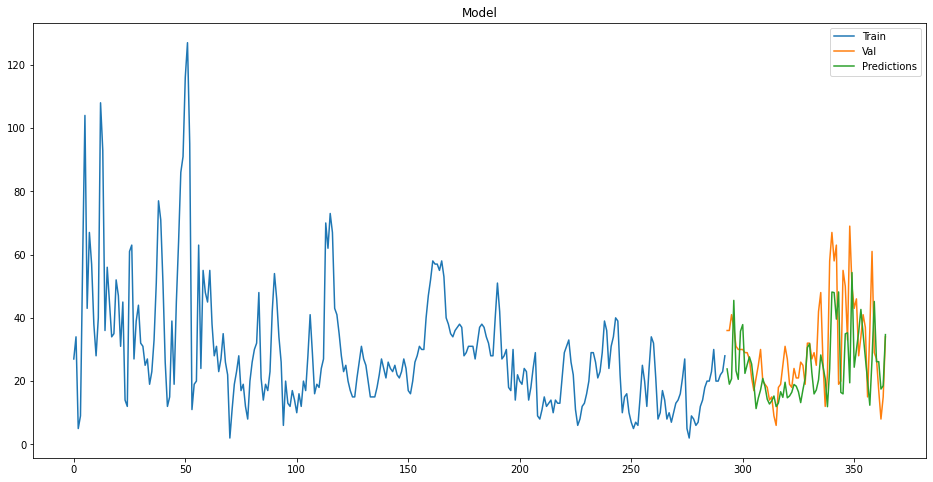

In [ ]:
train = df[:293]
valid = df[293:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(train['PM10'])
plt.plot(valid[['PM10', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

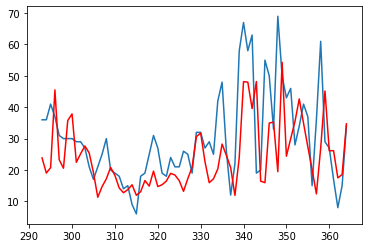

In [ ]:
pyplot.plot(valid['PM10'])
pyplot.plot(valid['Predictions'], color='red')

plt.savefig('dettaglio_FC.png')
files.download("dettaglio_FC.png")
pyplot.show()

## Altra CNN OK

In [ ]:
epochs = 1300 
batch = 64
lr = 0.000001
adam = optimizers.Adam(lr)

model_cnn_2 = Sequential()
model_cnn_2.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_2.add(MaxPooling1D(pool_size=(10, )))
model_cnn_2.add(Conv1D(filters=64, kernel_size=2))
model_cnn_2.add(Flatten())
model_cnn_2.add(Dense(1))
model_cnn_2.compile(loss=tf.losses.MeanAbsoluteError(), optimizer=RMSprop(), metrics=[tf.metrics.RootMeanSquaredError()]) #come loss fa poca differenza MAE o MSE
model_cnn_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 128)           384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             16448     
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 193       
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
m2tex(model_cnn_2)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
Layer (type)                   & Output Shape                & Param \#    \\ \hline \hline 
conv1d (Conv1D)                & (None, 46, 128)             & 384        \\ \hline 
max\_pooling1d (MaxPooling1D)   & (None, 4, 128)              & 0          \\ \hline 
conv1d\_1 (Conv1D)              & (None, 3, 64)               & 16448      \\ \hline 
flatten (Flatten)              & (None, 192)                 & 0          \\ \hline 
dense (Dense)                  & (None, 1)                   & 193        \\ \hline \hline 
Total params: 17,025 \\ 
Trainable params: 17,025 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for test.} 
\label{tab:model-summary} 
\end{table}


In [ ]:
cnn_2_history = model_cnn_2.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/1300
9/9 - 1s - loss: 152.2067 - root_mean_squared_error: 204.5870 - val_loss: 147.6967 - val_root_mean_squared_error: 148.6512
Epoch 2/1300
9/9 - 0s - loss: 91.0126 - root_mean_squared_error: 104.4175 - val_loss: 31.7748 - val_root_mean_squared_error: 35.6620
Epoch 3/1300
9/9 - 0s - loss: 67.6982 - root_mean_squared_error: 80.4054 - val_loss: 105.5501 - val_root_mean_squared_error: 106.8387
Epoch 4/1300
9/9 - 0s - loss: 69.9982 - root_mean_squared_error: 78.2547 - val_loss: 38.0539 - val_root_mean_squared_error: 41.3855
Epoch 5/1300
9/9 - 0s - loss: 58.5739 - root_mean_squared_error: 65.4735 - val_loss: 78.2954 - val_root_mean_squared_error: 80.0385
Epoch 6/1300
9/9 - 0s - loss: 57.1246 - root_mean_squared_error: 62.9563 - val_loss: 40.0021 - val_root_mean_squared_error: 43.5996
Epoch 7/1300
9/9 - 0s - loss: 50.9475 - root_mean_squared_error: 56.9894 - val_loss: 61.4590 - val_root_mean_squared_error: 63.8950
Epoch 8/1300
9/9 - 0s - loss: 54.2549 - root_mean_squared_error: 58.2

In [ ]:
predictions = model_cnn_2.predict(X_valid_series)
print('MAE: ' + str(mean_absolute_error(Y_valid, predictions)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y_valid, predictions))))

MAE: 10.008286899990505
RMSE: 13.973849900516798


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

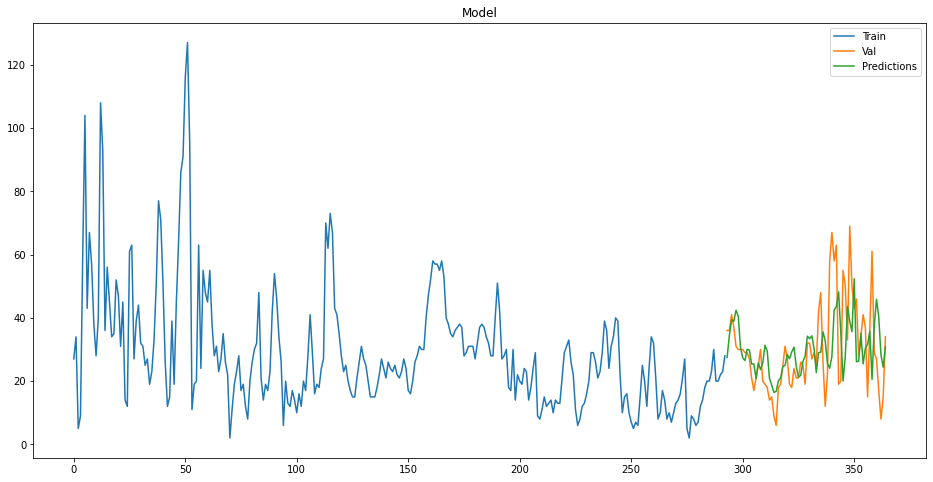

In [ ]:
train = df[:293]
valid = df[293:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.plot(train['PM10'])
plt.plot(valid[['PM10', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')

# plt.savefig('intero_CNN.png')
# files.download("intero_CNN.png")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

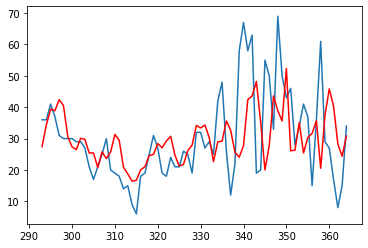

In [ ]:
pyplot.plot(valid['PM10'])
pyplot.plot(valid['Predictions'], color='red')

# plt.savefig('dettaglio_CNN.png')
# files.download("dettaglio_CNN.png")

pyplot.show()

## LSTM carrozzata


In [ ]:
epochs = 350
batch = 64
lr = 0.0001
adam = optimizers.Adam(lr)

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(250, return_sequences=True)) 
model_lstm.add(Dense(150))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))
model_lstm.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/350
9/9 - 6s - loss: 704.2710 - root_mean_squared_error: 26.5381 - val_loss: 245.9821 - val_root_mean_squared_error: 15.6838
Epoch 2/350
9/9 - 2s - loss: 380.6832 - root_mean_squared_error: 19.5111 - val_loss: 200.3807 - val_root_mean_squared_error: 14.1556
Epoch 3/350
9/9 - 2s - loss: 347.6128 - root_mean_squared_error: 18.6444 - val_loss: 210.2534 - val_root_mean_squared_error: 14.5001
Epoch 4/350
9/9 - 2s - loss: 348.7551 - root_mean_squared_error: 18.6750 - val_loss: 202.9762 - val_root_mean_squared_error: 14.2470
Epoch 5/350
9/9 - 2s - loss: 336.5706 - root_mean_squared_error: 18.3459 - val_loss: 195.2055 - val_root_mean_squared_error: 13.9716
Epoch 6/350
9/9 - 2s - loss: 320.8933 - root_mean_squared_error: 17.9135 - val_loss: 189.7203 - val_root_mean_squared_error: 13.7739
Epoch 7/350
9/9 - 2s - loss: 296.8703 - root_mean_squared_error: 17.2299 - val_loss: 179.1285 - val_root_mean_squared_error: 13.3839
Epoch 8/350
9/9 - 2s - loss: 279.4347 - root_mean_squared_error: 16.7

In [ ]:
# m2tex(model_lstm)

# model_lstm.summary()

In [ ]:
predictions = model_lstm.predict(X_valid_series)
print('MAE: ' + str(mean_absolute_error(Y_valid, predictions)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y_valid, predictions))))
# print(Y_valid)
# print(predictions)

MAE: 10.73103364970949
RMSE: 14.882036754908874


In [ ]:
train = df[:293]
valid = df[293:]
valid['Predictions'] = predictions

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

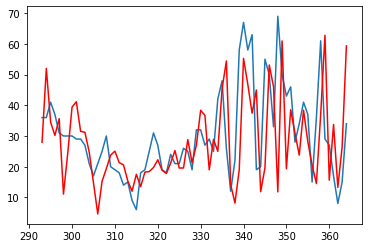

In [ ]:
pyplot.plot(valid['PM10'])
pyplot.plot(valid['Predictions'], color='red')

# plt.savefig('dettaglio_LSTM.png')
# files.download("dettaglio_LSTM.png")

pyplot.show()

In [ ]:
from google.colab import files
model_lstm.save(r'modello_lstm.h5')
files.download("modello_lstm.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modello per PM1

In [ ]:
dataset_finale = pd.read_excel(r'/content/drive/MyDrive/PM1.xlsx')
dataset_finale['Vento'] = dataset_finale['Vento'].map(lambda x: x.rstrip(' km/h')) # elimino il ' km/' 
dataset_finale = dataset_finale.astype({"Vento": int}) # trasformo in int
dataset_finale['Wind_Angle'] = dataset_finale['Wind Direction'].replace('N', 360).replace('NNE', 22.5).replace('NE', 45).replace('ENE', 67.5).replace(
  'E', 90).replace('ESE', 112.5).replace('SE', 135).replace('SSE', 157.5).replace('S', 180).replace('SSW', 202.5).replace('SW', 225).replace(
    'WSW', 247.5).replace('W', 270).replace('WNW', 292.5).replace('NW', 315).replace('NNW', 337.5)

PM1 = dataset_finale['PM1']
df = dataset_finale.drop(columns = ['Wind Direction', 'PM1', 'Unnamed: 0'])
df = pd.concat((df, PM1), axis = 1)
df = df.rename(columns = {'T Media': 'Temperature', 'H': 'Humidity', 'Vento': 'Wind_Speed', 'Pressione': 'Pressure'})
df.head()

,datetime,Temperature,Humidity,Wind_Speed,Pressure,Wind_Angle,PM1
0,2019-01-01,7,54,17,1023,22.5,16.0
1,2019-01-02,5,77,12,1014,67.5,20.0
2,2019-01-03,3,68,22,1019,22.5,3.0
3,2019-01-04,1,84,15,1025,360.0,6.0
4,2019-01-05,3,79,8,1022,337.5,35.0


In [ ]:
df = df.astype({"Wind_Angle": 'category'}) # converto l'angolo in type categorico
df.dtypes

datetime       datetime64[ns]
Temperature             int64
Humidity                int64
Wind_Speed              int64
Pressure                int64
Wind_Angle           category
PM1                   float64
dtype: object

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 6
lag = 1
series = series_to_supervised(df.drop('datetime', axis=1), window=window, lag=lag)
print(series.columns)
series.head()

Index(['Temperature(t-6)', 'Humidity(t-6)', 'Wind_Speed(t-6)', 'Pressure(t-6)',
       'Wind_Angle(t-6)', 'PM1(t-6)', 'Temperature(t-5)', 'Humidity(t-5)',
       'Wind_Speed(t-5)', 'Pressure(t-5)', 'Wind_Angle(t-5)', 'PM1(t-5)',
       'Temperature(t-4)', 'Humidity(t-4)', 'Wind_Speed(t-4)', 'Pressure(t-4)',
       'Wind_Angle(t-4)', 'PM1(t-4)', 'Temperature(t-3)', 'Humidity(t-3)',
       'Wind_Speed(t-3)', 'Pressure(t-3)', 'Wind_Angle(t-3)', 'PM1(t-3)',
       'Temperature(t-2)', 'Humidity(t-2)', 'Wind_Speed(t-2)', 'Pressure(t-2)',
       'Wind_Angle(t-2)', 'PM1(t-2)', 'Temperature(t-1)', 'Humidity(t-1)',
       'Wind_Speed(t-1)', 'Pressure(t-1)', 'Wind_Angle(t-1)', 'PM1(t-1)',
       'Temperature(t)', 'Humidity(t)', 'Wind_Speed(t)', 'Pressure(t)',
       'Wind_Angle(t)', 'PM1(t)', 'Temperature(t+1)', 'Humidity(t+1)',
       'Wind_Speed(t+1)', 'Pressure(t+1)', 'Wind_Angle(t+1)', 'PM1(t+1)'],
      dtype='object')


,Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM1(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM1(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM1(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM1(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM1(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM1(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t),PM1(t),Temperature(t+1),Humidity(t+1),Wind_Speed(t+1),Pressure(t+1),Wind_Angle(t+1),PM1(t+1)
6,7.0,54.0,17.0,1023.0,22.5,16.0,5.0,77.0,12.0,1014.0,67.5,20.0,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6,66,13,1024,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0
7,5.0,77.0,12.0,1014.0,67.5,20.0,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5,80,6,1019,67.5,39.0,7.0,83.0,13.0,1003.0,45.0,33.0
8,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7,83,13,1003,45.0,33.0,6.0,83.0,8.0,1005.0,22.5,22.0
9,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7.0,83.0,13.0,1003.0,45.0,33.0,6,83,8,1005,22.5,22.0,3.0,81.0,17.0,1014.0,45.0,17.0
10,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7.0,83.0,13.0,1003.0,45.0,33.0,6.0,83.0,8.0,1005.0,22.5,22.0,3,81,17,1014,45.0,17.0,4.0,81.0,13.0,1016.0,45.0,23.0


In [ ]:
n = len(series)
labels_col = 'PM1(t+1)'
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
X_train = series[0:int(n*0.8)] # (981) per avere gli ultimi 7 giorni come valid # per avere la prediction sugli ultimi 6 giorni moltiplica per 0.984, 0.960 per gli ultimi 15 giorni
X_valid = series[int(n*0.8):]
Y_train = labels[0:int(n*0.8)]
Y_valid = labels[int(n*0.8):]
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (148, 47)
Validation set shape (38, 47)


,Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM1(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM1(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM1(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM1(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM1(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM1(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t),PM1(t),Temperature(t+1),Humidity(t+1),Wind_Speed(t+1),Pressure(t+1),Wind_Angle(t+1)
6,7.0,54.0,17.0,1023.0,22.5,16.0,5.0,77.0,12.0,1014.0,67.5,20.0,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6,66,13,1024,67.5,25.0,5.0,80.0,6.0,1019.0,67.5
7,5.0,77.0,12.0,1014.0,67.5,20.0,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5,80,6,1019,67.5,39.0,7.0,83.0,13.0,1003.0,45.0
8,3.0,68.0,22.0,1019.0,22.5,3.0,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7,83,13,1003,45.0,33.0,6.0,83.0,8.0,1005.0,22.5
9,1.0,84.0,15.0,1025.0,360.0,6.0,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7.0,83.0,13.0,1003.0,45.0,33.0,6,83,8,1005,22.5,22.0,3.0,81.0,17.0,1014.0,45.0
10,3.0,79.0,8.0,1022.0,337.5,35.0,4.0,82.0,8.0,1019.0,67.5,59.0,6.0,66.0,13.0,1024.0,67.5,25.0,5.0,80.0,6.0,1019.0,67.5,39.0,7.0,83.0,13.0,1003.0,45.0,33.0,6.0,83.0,8.0,1005.0,22.5,22.0,3,81,17,1014,45.0,17.0,4.0,81.0,13.0,1016.0,45.0


In [ ]:
# per dati non scalati

X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (148, 47, 1)
Validation set shape (38, 47, 1)


In [ ]:
epochs = 1000
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)

In [ ]:
model_lstm_PM1 = Sequential()
model_lstm_PM1.add(LSTM(250, return_sequences=True)) # _series , , activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])
model_lstm_PM1.add(Dense(150))
model_lstm_PM1.add(LSTM(50, activation='relu'))
model_lstm_PM1.add(Dense(25))
model_lstm_PM1.add(Dense(1))
model_lstm_PM1.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
lstm_history_PM1 = model_lstm_PM1.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/1000
5/5 - 5s - loss: 318.0146 - root_mean_squared_error: 17.8330 - val_loss: 450.6714 - val_root_mean_squared_error: 21.2290
Epoch 2/1000
5/5 - 1s - loss: 318.8886 - root_mean_squared_error: 17.8575 - val_loss: 833.0557 - val_root_mean_squared_error: 28.8627
Epoch 3/1000
5/5 - 1s - loss: 294.0763 - root_mean_squared_error: 17.1487 - val_loss: 57.5551 - val_root_mean_squared_error: 7.5865
Epoch 4/1000
5/5 - 1s - loss: 212.8847 - root_mean_squared_error: 14.5906 - val_loss: 27.3941 - val_root_mean_squared_error: 5.2339
Epoch 5/1000
5/5 - 1s - loss: 219.1405 - root_mean_squared_error: 14.8034 - val_loss: 28.4514 - val_root_mean_squared_error: 5.3340
Epoch 6/1000
5/5 - 1s - loss: 194.7953 - root_mean_squared_error: 13.9569 - val_loss: 42.9816 - val_root_mean_squared_error: 6.5560
Epoch 7/1000
5/5 - 1s - loss: 148.9099 - root_mean_squared_error: 12.2029 - val_loss: 167.6740 - val_root_mean_squared_error: 12.9489
Epoch 8/1000
5/5 - 1s - loss: 145.3680 - root_mean_squared_error: 12.0

In [ ]:
predictions = model_lstm_PM1.predict(X_valid_series)
print('MAE: ' + str(mean_absolute_error(Y_valid, predictions)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y_valid, predictions))))

MAE: 4.108616841466803
RMSE: 4.82591712640839


In [ ]:
predictions = predictions.astype(int)

In [ ]:
df = series.dropna()
train = df[:148]
valid = df[148:]
valid['Predictions'] = predictions

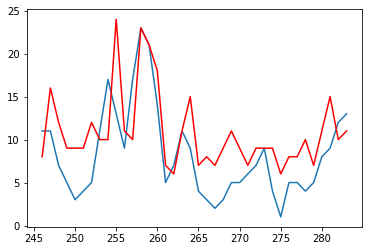

In [ ]:
pyplot.plot(Y_valid)
pyplot.plot(valid['Predictions'], color='red')

# plt.savefig('dettaglio_LSTM_PM1.png')
# files.download("dettaglio_LSTM_PM1.png")
pyplot.show()

In [ ]:
from google.colab import files
model_lstm_PM1.save(r'modello_lstm_PM1.h5')
files.download("modello_lstm_PM1.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modello per PM2.5

In [ ]:
dataset_finale = pd.read_excel(r'/content/drive/MyDrive/PM2_5.xlsx')
dataset_finale['Vento'] = dataset_finale['Vento'].map(lambda x: x.rstrip(' km/h')) # elimino il ' km/' 
dataset_finale = dataset_finale.astype({"Vento": int}) # trasformo in int
dataset_finale['Wind_Angle'] = dataset_finale['Wind Direction'].replace('N', 360).replace('NNE', 22.5).replace('NE', 45).replace('ENE', 67.5).replace(
  'E', 90).replace('ESE', 112.5).replace('SE', 135).replace('SSE', 157.5).replace('S', 180).replace('SSW', 202.5).replace('SW', 225).replace(
    'WSW', 247.5).replace('W', 270).replace('WNW', 292.5).replace('NW', 315).replace('NNW', 337.5)

PM2_5 = dataset_finale['PM2_5']
df = dataset_finale.drop(columns = ['Wind Direction', 'PM2_5', 'Unnamed: 0'])
df = pd.concat((df, PM2_5), axis = 1)
df = df.rename(columns = {'T Media': 'Temperature', 'H': 'Humidity', 'Vento': 'Wind_Speed', 'Pressione': 'Pressure'})
df.head()

,datetime,Temperature,Humidity,Wind_Speed,Pressure,Wind_Angle,PM2_5
0,2019-01-01,7,54,17,1023,22.5,21.0
1,2019-01-02,5,77,12,1014,67.5,28.0
2,2019-01-03,3,68,22,1019,22.5,5.0
3,2019-01-04,1,84,15,1025,360.0,8.0
4,2019-01-05,3,79,8,1022,337.5,44.0


In [ ]:
df = df.astype({"Wind_Angle": 'category'}) # converto l'angolo in type categorico
df.dtypes

datetime       datetime64[ns]
Temperature             int64
Humidity                int64
Wind_Speed              int64
Pressure                int64
Wind_Angle           category
PM2_5                 float64
dtype: object

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    for i in range(1):
        cols.append(data.shift(i))
        names += [('%s(t+%d)' % (col, i)) for col in data.columns]
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 6
lag = 1
series = series_to_supervised(df.drop('datetime', axis=1), window=window, lag=lag)

print(series.columns)

series.head()

Index(['Temperature(t-6)', 'Humidity(t-6)', 'Wind_Speed(t-6)', 'Pressure(t-6)',
       'Wind_Angle(t-6)', 'PM2_5(t-6)', 'Temperature(t-5)', 'Humidity(t-5)',
       'Wind_Speed(t-5)', 'Pressure(t-5)', 'Wind_Angle(t-5)', 'PM2_5(t-5)',
       'Temperature(t-4)', 'Humidity(t-4)', 'Wind_Speed(t-4)', 'Pressure(t-4)',
       'Wind_Angle(t-4)', 'PM2_5(t-4)', 'Temperature(t-3)', 'Humidity(t-3)',
       'Wind_Speed(t-3)', 'Pressure(t-3)', 'Wind_Angle(t-3)', 'PM2_5(t-3)',
       'Temperature(t-2)', 'Humidity(t-2)', 'Wind_Speed(t-2)', 'Pressure(t-2)',
       'Wind_Angle(t-2)', 'PM2_5(t-2)', 'Temperature(t-1)', 'Humidity(t-1)',
       'Wind_Speed(t-1)', 'Pressure(t-1)', 'Wind_Angle(t-1)', 'PM2_5(t-1)',
       'Temperature(t)', 'Humidity(t)', 'Wind_Speed(t)', 'Pressure(t)',
       'Wind_Angle(t)', 'PM2_5(t)', 'Temperature(t+1)', 'Humidity(t+1)',
       'Wind_Speed(t+1)', 'Pressure(t+1)', 'Wind_Angle(t+1)', 'PM2_5(t+1)'],
      dtype='object')


,Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM2_5(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM2_5(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM2_5(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM2_5(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM2_5(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM2_5(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t),PM2_5(t),Temperature(t+1),Humidity(t+1),Wind_Speed(t+1),Pressure(t+1),Wind_Angle(t+1),PM2_5(t+1)
6,7.0,54.0,17.0,1023.0,22.5,21.0,5.0,77.0,12.0,1014.0,67.5,28.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6,66,13,1024,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0
7,5.0,77.0,12.0,1014.0,67.5,28.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5,80,6,1019,67.5,51.0,7.0,83.0,13.0,1003.0,45.0,46.0
8,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7,83,13,1003,45.0,46.0,6.0,83.0,8.0,1005.0,22.5,29.0
9,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7.0,83.0,13.0,1003.0,45.0,46.0,6,83,8,1005,22.5,29.0,3.0,81.0,17.0,1014.0,45.0,24.0
10,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7.0,83.0,13.0,1003.0,45.0,46.0,6.0,83.0,8.0,1005.0,22.5,29.0,3,81,17,1014,45.0,24.0,4.0,81.0,13.0,1016.0,45.0,32.0


In [ ]:
n = len(series)
labels_col = 'PM2_5(t)'
labels = series[labels_col]
series = series.drop(labels_col, axis=1)
X_train = series[0:int(n*0.8)] # (981) per avere gli ultimi 7 giorni come valid # per avere la prediction sugli ultimi 6 giorni moltiplica per 0.984, 0.960 per gli ultimi 15 giorni
X_valid = series[int(n*0.8):]
Y_train = labels[0:int(n*0.8)]
Y_valid = labels[int(n*0.8):]
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (150, 41)
Validation set shape (38, 41)


,Temperature(t-6),Humidity(t-6),Wind_Speed(t-6),Pressure(t-6),Wind_Angle(t-6),PM2_5(t-6),Temperature(t-5),Humidity(t-5),Wind_Speed(t-5),Pressure(t-5),Wind_Angle(t-5),PM2_5(t-5),Temperature(t-4),Humidity(t-4),Wind_Speed(t-4),Pressure(t-4),Wind_Angle(t-4),PM2_5(t-4),Temperature(t-3),Humidity(t-3),Wind_Speed(t-3),Pressure(t-3),Wind_Angle(t-3),PM2_5(t-3),Temperature(t-2),Humidity(t-2),Wind_Speed(t-2),Pressure(t-2),Wind_Angle(t-2),PM2_5(t-2),Temperature(t-1),Humidity(t-1),Wind_Speed(t-1),Pressure(t-1),Wind_Angle(t-1),PM2_5(t-1),Temperature(t),Humidity(t),Wind_Speed(t),Pressure(t),Wind_Angle(t)
6,7.0,54.0,17.0,1023.0,22.5,21.0,5.0,77.0,12.0,1014.0,67.5,28.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6,66,13,1024,67.5
7,5.0,77.0,12.0,1014.0,67.5,28.0,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5,80,6,1019,67.5
8,3.0,68.0,22.0,1019.0,22.5,5.0,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7,83,13,1003,45.0
9,1.0,84.0,15.0,1025.0,360.0,8.0,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7.0,83.0,13.0,1003.0,45.0,46.0,6,83,8,1005,22.5
10,3.0,79.0,8.0,1022.0,337.5,44.0,4.0,82.0,8.0,1019.0,67.5,76.0,6.0,66.0,13.0,1024.0,67.5,35.0,5.0,80.0,6.0,1019.0,67.5,51.0,7.0,83.0,13.0,1003.0,45.0,46.0,6.0,83.0,8.0,1005.0,22.5,29.0,3,81,17,1014,45.0


In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (150, 41, 1)
Validation set shape (38, 41, 1)


In [ ]:
epochs = 1000
batch = 32
lr = 0.00001
adam = optimizers.Adam(lr)

In [ ]:
from tensorflow.keras import layers, activations

model_lstm_PM2_5 = Sequential()
model_lstm_PM2_5.add(LSTM(250, return_sequences=True)) # _series , , activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])
model_lstm_PM2_5.add(Dense(150))
model_lstm_PM2_5.add(LSTM(50, activation='relu')) 
model_lstm_PM2_5.add(Dense(25))
model_lstm_PM2_5.add(Dense(1, activation = 'relu')) 
model_lstm_PM2_5.compile(loss=tf.losses.MeanSquaredError(), optimizer='adam', metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
lstm_history_PM2_5 = model_lstm_PM2_5.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/1000
5/5 - 5s - loss: 729.1980 - root_mean_squared_error: 27.0037 - val_loss: 1234.8306 - val_root_mean_squared_error: 35.1402
Epoch 2/1000
5/5 - 1s - loss: 395.6498 - root_mean_squared_error: 19.8909 - val_loss: 159.4304 - val_root_mean_squared_error: 12.6266
Epoch 3/1000
5/5 - 1s - loss: 233.8180 - root_mean_squared_error: 15.2911 - val_loss: 119.3915 - val_root_mean_squared_error: 10.9266
Epoch 4/1000
5/5 - 1s - loss: 1149.6095 - root_mean_squared_error: 33.9059 - val_loss: 112.8799 - val_root_mean_squared_error: 10.6245
Epoch 5/1000
5/5 - 1s - loss: 249.9978 - root_mean_squared_error: 15.8113 - val_loss: 183.6880 - val_root_mean_squared_error: 13.5532
Epoch 6/1000
5/5 - 1s - loss: 236.0610 - root_mean_squared_error: 15.3643 - val_loss: 216.8041 - val_root_mean_squared_error: 14.7243
Epoch 7/1000
5/5 - 1s - loss: 221.6481 - root_mean_squared_error: 14.8879 - val_loss: 224.6382 - val_root_mean_squared_error: 14.9879
Epoch 8/1000
5/5 - 1s - loss: 222.8335 - root_mean_squared_e

In [ ]:
predictions = model_lstm_PM2_5.predict(X_valid_series)
print('MAE: ' + str(mean_absolute_error(Y_valid, predictions)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y_valid, predictions))))

In [ ]:
predictions = predictions.astype(int)

In [ ]:
df = series.dropna()
train = df[:150]
valid = df[150:]
valid['Predictions'] = predictions

In [ ]:
pyplot.plot(Y_valid)
pyplot.plot(valid['Predictions'], color='red')

# plt.savefig('dettaglio_LSTM_PM2_5.png')
# files.download("dettaglio_LSTM_PM2_5.png")
pyplot.show()

In [ ]:
# from google.colab import files
# model_lstm_PM2_5.save(r'modello_lstm_PM2_5.h5')
# files.download("modello_lstm_PM2_5.h5")